In [36]:
import cv2
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
mass_training_file = "C:\\Users\\tonywang\\Desktop\DDSM\mass_case_path_train_density.csv"
f = open(mass_training_file, 'r')
def read_dcm_image(path):
        ds = sitk.ReadImage(path)
        img_array = sitk.GetArrayFromImage(ds)
        return img_array[0]
def rotate90(src):
        img_copy = src.copy()
        img_copy = cv2.transpose(img_copy)
        img_copy = cv2.flip(img_copy, 1)
        return img_copy
    
num_line=0
train_image=[]
train_label=[]
test_image = []
test_label = []

for line in f:
    if num_line >=2:
        break
    num_line += 1
    line = line.rstrip()
    l = line.split(",")
    if len(l) <= 2:
        continue
    print("Loading training data:" + l[0])
    image_path = l[2] + l[3]
    #print("image_path: "+ image_path)
    a=[0,0,0,0]
    l[1]
    train_label.append(l[1])
    print('l長度 ',len(l))
    img = (read_dcm_image(image_path))
    b = rotate90(img)
    smallimage=cv2.resize(img,(224,224), interpolation=cv2.INTER_CUBIC)
    smallimageb=cv2.resize(b,(224,224), interpolation=cv2.INTER_CUBIC)
    train_image.append(smallimage)
    array_train_image = np.array(train_image)
    
print('train_image ', array_train_image.shape)
print('train_image ', array_train_image)
#print('train_label ', train_label)
"""
plt.imshow(img ,cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

plt.imshow(b ,cmap='gray')
plt.title('rotate 90 degrees image')
plt.axis('off')
plt.show()

plt.imshow(smallimage ,cmap='gray')
plt.title('resize original image')
plt.axis('off')
plt.show()

plt.imshow(smallimageb ,cmap='gray')
plt.title('resize & rotate 90 degrees image')
plt.axis('off')
plt.show()
"""

In [ ]:

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Hyperparameter
growth_k = 12
nb_block = 4 # how many (dense block + Transition Layer) ?
init_learning_rate = 1e-4
epsilon = 1e-8 # AdamOptimizer epsilon
dropout_rate = 0.2

# Momentum Optimizer will use
nesterov_momentum = 0.9
weight_decay = 1e-4

# Label & batch_size
class_num = 4
batch_size = 60

total_epochs = 100


def conv_layer(input, filter, kernel, stride=1, layer_name="conv"):
    with tf.name_scope(layer_name):
        network = tf.layers.conv2d(inputs=input, filters=filter, kernel_size=kernel, strides=stride, padding='SAME')
        return network

def Global_Average_Pooling(x, stride=1):
    """
    width = np.shape(x)[1]
    height = np.shape(x)[2]
    pool_size = [width, height]
    return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride) # The stride value does not matter
    It is global average pooling without tflearn
    """

    return global_avg_pool(x, name='Global_avg_pooling')
    # But maybe you need to install h5py and curses or not


def Batch_Normalization(x, training, scope):
    with arg_scope([batch_norm],
                   scope=scope,
                   updates_collections=None,
                   decay=0.9,
                   center=True,
                   scale=True,
                   zero_debias_moving_mean=True) :
        return tf.cond(training,
                       lambda : batch_norm(inputs=x, is_training=training, reuse=None),
                       lambda : batch_norm(inputs=x, is_training=training, reuse=True))

def Drop_out(x, rate, training) :
    return tf.layers.dropout(inputs=x, rate=rate, training=training)

def Relu(x):
    return tf.nn.relu(x)

def Average_pooling(x, pool_size=[2,2], stride=2, padding='VALID'):
    return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)


def Max_Pooling(x, pool_size=[3,3], stride=2, padding='VALID'):
    return tf.layers.max_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)

def Concatenation(layers) :
    return tf.concat(layers, axis=3)

def Linear(x) :
    return tf.layers.dense(inputs=x, units=class_num, name='linear')



class DenseNet():
    def __init__(self, x, nb_blocks, filters, training):
        self.nb_blocks = nb_blocks
        self.filters = filters
        self.training = training
        self.model = self.Dense_net(x)


    def bottleneck_layer(self, x, scope):
        # print(x)
        with tf.name_scope(scope):
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)
            x = conv_layer(x, filter=4 * self.filters, kernel=[1,1], layer_name=scope+'_conv1')
            x = Drop_out(x, rate=dropout_rate, training=self.training)

            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch2')
            x = Relu(x)
            x = conv_layer(x, filter=self.filters, kernel=[3,3], layer_name=scope+'_conv2')
            x = Drop_out(x, rate=dropout_rate, training=self.training)

            # print(x)

            return x

    def transition_layer(self, x, scope):
        with tf.name_scope(scope):
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)
            x = conv_layer(x, filter=self.filters, kernel=[1,1], layer_name=scope+'_conv1')
            x = Drop_out(x, rate=dropout_rate, training=self.training)
            x = Average_pooling(x, pool_size=[2,2], stride=2)

            return x

    def dense_block(self, input_x, nb_layers, layer_name):
        with tf.name_scope(layer_name):
            layers_concat = list()
            layers_concat.append(input_x)

            x = self.bottleneck_layer(input_x, scope=layer_name + '_bottleN_' + str(0))

            layers_concat.append(x)

            for i in range(nb_layers - 1):
                x = Concatenation(layers_concat)
                x = self.bottleneck_layer(x, scope=layer_name + '_bottleN_' + str(i + 1))
                layers_concat.append(x)

            return x

    def Dense_net(self, input_x):
        x = conv_layer(input_x, filter=2 * self.filters, kernel=[7,7], stride=2, layer_name='conv0')
        x = Max_Pooling(x, pool_size=[3,3], stride=2)



        for i in range(self.nb_blocks) :
            # 6 -> 12 -> 48
            x = self.dense_block(input_x=x, nb_layers=4, layer_name='dense_'+str(i))
            x = self.transition_layer(x, scope='trans_'+str(i))


        """
        x = self.dense_block(input_x=x, nb_layers=6, layer_name='dense_1')
        x = self.transition_layer(x, scope='trans_1')

        x = self.dense_block(input_x=x, nb_layers=12, layer_name='dense_2')
        x = self.transition_layer(x, scope='trans_2')

        x = self.dense_block(input_x=x, nb_layers=48, layer_name='dense_3')
        x = self.transition_layer(x, scope='trans_3')
        """

        x = self.dense_block(input_x=x, nb_layers=32, layer_name='dense_final')

        # 100 Layer
        x = Batch_Normalization(x, training=self.training, scope='linear_batch')
        x = Relu(x)
        x = Global_Average_Pooling(x)
        x = flatten(x)
        x = Linear(x)


        # x = tf.reshape(x, [-1, 10])
        return x

#前處理縮小成224*224=



In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 50176])
batch_images = tf.reshape(x, [-1, 224, 224, 1])

label = tf.placeholder(tf.float32, shape=[None, 4])

training_flag = tf.placeholder(tf.bool)


learning_rate = tf.placeholder(tf.float32, name='learning_rate')
logits = DenseNet(x=batch_images, nb_blocks=nb_block, filters=growth_k, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits))


Loading training data:P_00001
l長度  10
Loading training data:P_00001
l長度  10


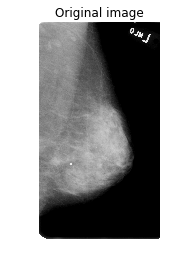

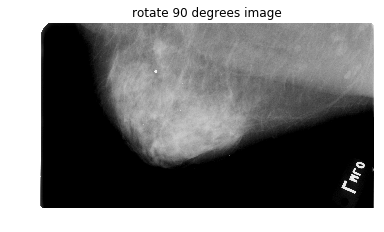

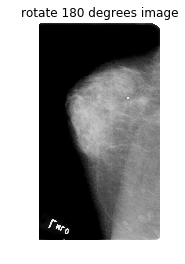

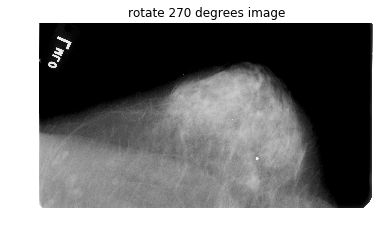

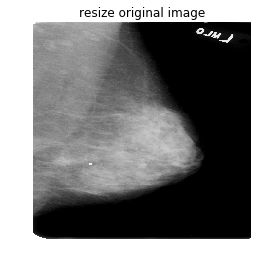

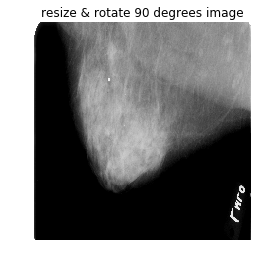

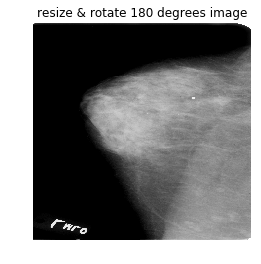

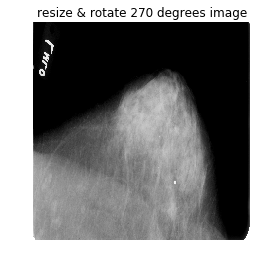

In [39]:
import csv
import os
import sys
from datetime import datetime
import cv2
import SimpleITK as sitk
from time import strftime
mass_training_file = "C:\\Users\\tonywang\\Desktop\\DDSM\\mass_case_path_train_density.csv"
f = open(mass_training_file, 'r')
def read_dcm_image(path):
        ds = sitk.ReadImage(path)
        img_array = sitk.GetArrayFromImage(ds)
        return img_array[0]
def rotate90(src):
        img_copy = src.copy()
        img_copy = cv2.transpose(img_copy)
        img_copy = cv2.flip(img_copy, 1)
        return img_copy
    
num_line=0
train_image=[]
train_label=[]
test_image = []
test_label = []
pathProg = 'C:\\Users\\tonywang\\Desktop\\test'
os.chdir(pathProg)

if os.getcwd() != pathProg:
    print("EEROR: the file path incorrect.")
    sys.exit()

file = open(pathProg + '\density_input.csv', 'w', newline='')
csvCursor = csv.writer(file)
for line in f:
    if num_line >=2:
        break
    num_line += 1
    line = line.rstrip()
    l = line.split(",")
    if len(l) <= 2:
        continue
    print("Loading training data:" + l[0])
    image_path = l[2] + l[3]
    #print("image_path: "+ image_path)
    a=[0,0,0,0]
    l[1]
    train_label.append(l[1])
    print('l長度 ',len(l))
    img = (read_dcm_image(image_path))
    b = rotate90(img)
    c = rotate90(b)
    d = rotate90(c)
    smallimage=cv2.resize(img,(224,224), interpolation=cv2.INTER_CUBIC)
    smallimageb=cv2.resize(b,(224,224), interpolation=cv2.INTER_CUBIC)
    smallimagec=cv2.resize(c,(224,224), interpolation=cv2.INTER_CUBIC)
    smallimaged=cv2.resize(d,(224,224), interpolation=cv2.INTER_CUBIC)
    train_image.append(smallimage)
    train_image.append(smallimageb)
    train_image.append(smallimagec)
    train_image.append(smallimaged)
   
#print('train_image ', array_train_image)
for i in train_image:
    csvCursor.writerow([i])  
  
file.close()
plt.imshow(img ,cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

plt.imshow(b ,cmap='gray')
plt.title('rotate 90 degrees image')
plt.axis('off')
plt.show()
plt.imshow(c ,cmap='gray')
plt.title('rotate 180 degrees image')
plt.axis('off')
plt.show()
plt.imshow(d ,cmap='gray')
plt.title('rotate 270 degrees image')
plt.axis('off')
plt.show()

plt.imshow(smallimage ,cmap='gray')
plt.title('resize original image')
plt.axis('off')
plt.show()

plt.imshow(smallimageb ,cmap='gray')
plt.title('resize & rotate 90 degrees image')
plt.axis('off')
plt.show()
plt.imshow(smallimagec ,cmap='gray')
plt.title('resize & rotate 180 degrees image')
plt.axis('off')
plt.show()
plt.imshow(smallimaged ,cmap='gray')
plt.title('resize & rotate 270 degrees image')
plt.axis('off')
plt.show()

In [29]:
import csv
import os
import sys
import numpy as np
pathProg = 'C:\\Users\\tonywang\\Desktop\\test'
os.chdir(pathProg)

if os.getcwd() != pathProg:
    print("EEROR: the file path incorrect.")
    sys.exit()

file = open(pathProg + '\density_input2.csv', 'w', newline='')
csvCursor = csv.writer(file)
test=np.array([[[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]],[[5,5,5,5],[5,5,5,5],[5,5,5,5],[5,5,5,5]]])
for i in test:
    csvCursor.writerow([i])  
